In [2]:
# imports for data processing
import pandas as pd
import glob
import pandas as pd
import numpy as np
import datetime
import math
from ast import literal_eval
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
from ast import literal_eval

# imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# imports for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# imports for logistic regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import train_test_split

In [3]:
# Functions
def ct_numbers_list(ct_numbers_in_heart):
    ls = literal_eval(ct_numbers_in_heart)
    ints = list()
    for x in ls:
        ints.append(int(x))
    return(ints)


def consolidate_data(df, included_cacs):
    d = list()
    for patient_id in df.pt_id.unique():
        dfp = df[df.pt_id == patient_id]

        data = {'patient_id': patient_id,
                'total_score': dfp.total_score.max(),
                'label': 1 if dfp.total_score.max() >= 100 else 0,
                'total_hhua_pixels':dfp.number_of_pixels.sum(),
                'cts_with_cac': len(dfp.ct_number.unique()),
                'slice_thickness': dfp.slice_thickness.max(),
                'pixel_spacing_1': dfp.pixel_spacing_1.max(),
                }
                
        dfp.sort_values(by=['number_of_pixels'])
        dfp = dfp.reset_index()

        dfp['center_lit'] = dfp.center_min_circle.apply(literal_eval)
        dfp['center_1'] = 0
        dfp['center_2'] = 0
        dfp.loc[:, 'center_1'] = dfp.center_lit.map(lambda x: x[0])
        dfp.loc[:, 'center_2'] = dfp.center_lit.map(lambda x: x[1])

        dfp['cropedlit'] = dfp.croped_slice_shape.apply(literal_eval)
        dfp['croped_1'] = 0
        dfp['croped_2'] = 0
        dfp.loc[:, 'croped_1'] = dfp.cropedlit.map(lambda x: x[0])
        dfp.loc[:, 'croped_2'] = dfp.cropedlit.map(lambda x: x[1])
     
        for i in range(included_cacs):
            try:
                data[f'hhua_{i}_area'] = dfp.iloc[i].number_of_pixels  * data['pixel_spacing_1']**2 

                data[f'hhua_{i}_dist_x1'] = dfp.iloc[i]['center_1'] * data['pixel_spacing_1']
                data[f'hhua_{i}_dist_x2'] = (dfp.iloc[i]['croped_1'] - dfp.iloc[i]['center_1'])* data['pixel_spacing_1']

                data[f'hhua_{i}_dist_y1'] = dfp.iloc[i]['center_2'] * data['pixel_spacing_1']
                data[f'hhua_{i}_dist_y2'] = (dfp.iloc[i]['croped_2'] - dfp.iloc[i]['center_2'])* data['pixel_spacing_1']

                data[f'hhua_{i}_dist_z1'] = (dfp.iloc[i].ct_max - dfp.iloc[i].ct_number) * data['slice_thickness']
                data[f'hhua_{i}_dist_z2'] = (dfp.iloc[i].ct_number - dfp.iloc[i].ct_min ) * data['slice_thickness']

                data[f'hhua_{i}_ct_number'] = dfp.iloc[i].ct_number

                data[f'hhua_{i}_max_pixel_value'] = dfp.iloc[i].max_pixel_value
                data[f'hhua_{i}_min_pixel_value'] = dfp.iloc[i].min_pixel_value
                data[f'hhua_{i}_mean_pixel_value'] = dfp.iloc[i].mean_pixel_value
                
            except IndexError:
                data[f'hhua_{i}_area'] = 0
                data[f'hhua_{i}_ct_number'] = 0
                data[f'hhua_{i}_dist_x1'] = 0
                data[f'hhua_{i}_dist_y1'] = 0
                data[f'hhua_{i}_dist_z1'] = 0
                data[f'hhua_{i}_dist_x2'] = 0
                data[f'hhua_{i}_dist_y2'] = 0
                data[f'hhua_{i}_dist_z2'] = 0
                data[f'hhua_{i}_max_pixel_value'] = 0
                data[f'hhua_{i}_min_pixel_value'] = 0
                data[f'hhua_{i}_mean_pixel_value'] = 0

        d.append(data)
    return(d)    

In [4]:
df_patients = pd.read_csv("DSproject/patient_overview_train.csv")
df_manual = pd.read_csv("DSproject/manual_labels_train.csv")
df_slices = pd.read_csv("DSproject/ct_slices_train.csv")

df_patients = pd.merge(df_patients, df_manual[['pt_id', 'Total_score']], on='pt_id')
df_patients['ct_list'] = df_patients.ct_numbers_in_heart.apply(ct_numbers_list)
df_patients['ct_max'] = df_patients.ct_list.apply(max)
df_patients['ct_min'] = df_patients.ct_list.apply(min)
df_patients['ct_len'] = df_patients.ct_list.apply(len)

df_slices['number_of_pixels'] = df_slices.pixel_values_hu.apply(literal_eval).apply(len)
df_slices['max_pixel_value'] = df_slices.pixel_values_hu.apply(literal_eval).apply(max)
df_slices['min_pixel_value'] = df_slices.pixel_values_hu.apply(literal_eval).apply(min)
df_slices['mean_pixel_value'] = df_slices.pixel_values_hu.apply(literal_eval).apply(np.mean)

# apply the same total score to all slices of the same patient
df_slices['total_score'] = 0
for patient_id in df_slices.pt_id.unique():
    df_slices.loc[(df_slices.pt_id == patient_id), 'total_score'] = df_patients.loc[(df_patients.pt_id == patient_id), 'Total_score'].values[0]

df_slices['ct_max']= 0
df_slices['ct_min'] =0

for patient_id in df_slices.pt_id.unique():
    df_slices.loc[(df_slices.pt_id == patient_id), 'ct_max'] = df_patients.loc[(df_patients.pt_id == patient_id), 'ct_max'].values[0]
    df_slices.loc[(df_slices.pt_id == patient_id), 'ct_min'] = df_patients.loc[(df_patients.pt_id == patient_id), 'ct_min'].values[0]

C:\Users\frede\AppData\Local\Temp\ipykernel_23808\3744106524.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_slices.loc[(df_slices.pt_id == patient_id), 'total_score'] = df_patients.loc[(df_patients.pt_id == patient_id), 'Total_score'].values[0]


In [5]:
# We will now be making a neural network using the knowledge we gained from our logistic regression model.

# We saw that 29 lesions were enough to get a good prediction of the total score. We will use this number of lesions to train our neural network.
df_features = pd.DataFrame(consolidate_data(df_slices, 29))

# drop rows with slice_thickness == 5.0
df_features = df_features[df_features.slice_thickness != 5.0]

X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values
y = df_features.total_score.values

In [77]:
# imports for neural network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import regularizers

In [80]:
X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values
y = df_features.total_score.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# standardize the X_train
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.where(y_train < 100, 0, 1)
y_test_cat = np.where(y_test < 100, 0, 1)

# Define the model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l1'))
model.add(Dense(1, activation='sigmoid'))

# Use the function when compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the class weights using the formula weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)
weight_for_0 = len(df_features) / (len(df_features[df_features.label == 0]) * 2)
weight_for_1 = len(df_features) / (len(df_features[df_features.label == 1]) * 2)
weights = {0: weight_for_0, 1: weight_for_1}

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test_cat), epochs=500, batch_size=64, class_weight=weights, verbose=0) 

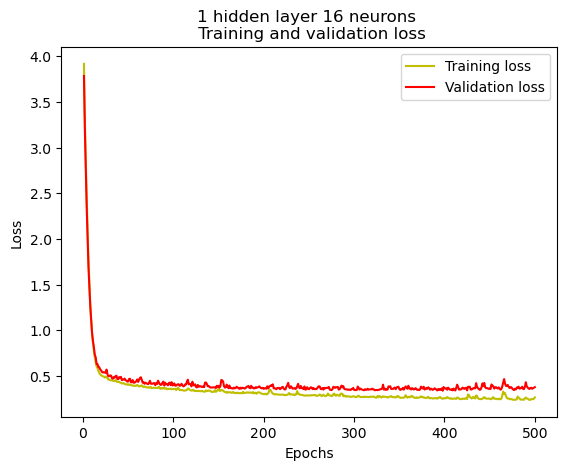

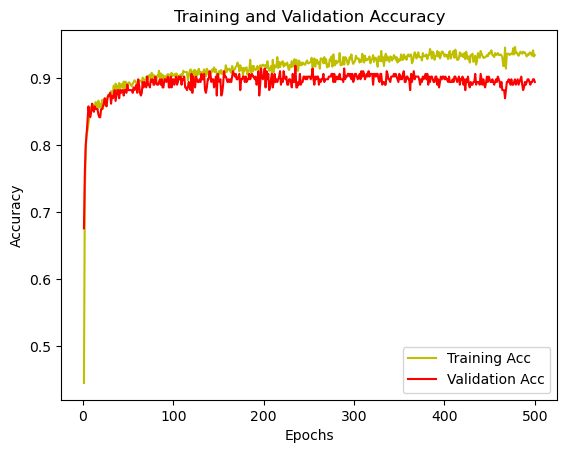

In [81]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('1 hidden layer 16 neurons \n Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label = 'Training Acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# We see that with one layer and the number of neurons we chose, we get a fairly good result, but the model is overfitting. 
# We will now try to improve the model by adding one more layer:

In [88]:
X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values
y = df_features.total_score.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# standardize the X_train
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.where(y_train < 100, 0, 1)
y_test_cat = np.where(y_test < 100, 0, 1)

# Define the model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l1'))
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l1'))
model.add(Dense(1, activation='sigmoid'))

# Use the function when compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the class weights using the formula weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)
weight_for_0 = len(df_features) / (len(df_features[df_features.label == 0]) * 2)
weight_for_1 = len(df_features) / (len(df_features[df_features.label == 1]) * 2)
weights = {0: weight_for_0, 1: weight_for_1}

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test_cat), epochs=500, batch_size=64, class_weight=weights, verbose=0) 

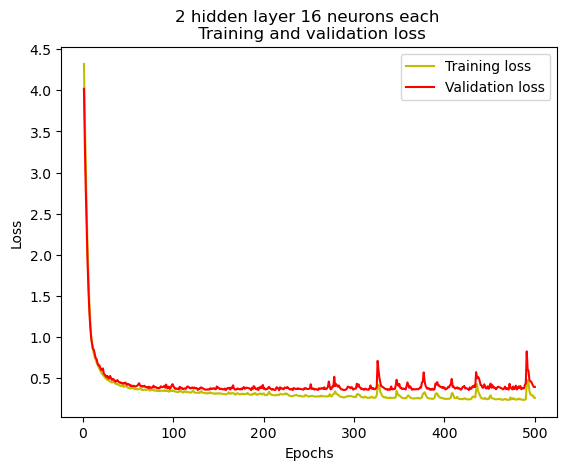

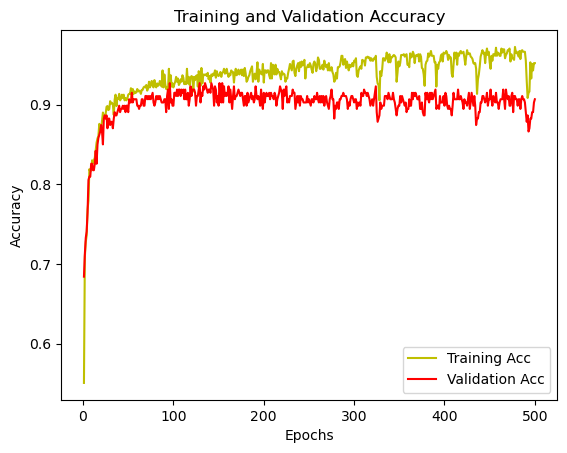

In [89]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('2 hidden layer 16 neurons each \n Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label = 'Training Acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# This model peaks at a higher accuracy than the previous one, but it is still overfitting.
# To deal with this we will add dropout layers to the model with a dropout rate of 0.2:

In [92]:
X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values
y = df_features.total_score.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# standardize the X_train
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.where(y_train < 100, 0, 1)
y_test_cat = np.where(y_test < 100, 0, 1)

# Define the model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l1'))
model.add(Dropout(0.2))
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l1'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Use the function when compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the class weights using the formula weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)
weight_for_0 = len(df_features) / (len(df_features[df_features.label == 0]) * 2)
weight_for_1 = len(df_features) / (len(df_features[df_features.label == 1]) * 2)
weights = {0: weight_for_0, 1: weight_for_1}

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test_cat), epochs=500, batch_size=64, class_weight=weights, verbose=0) 

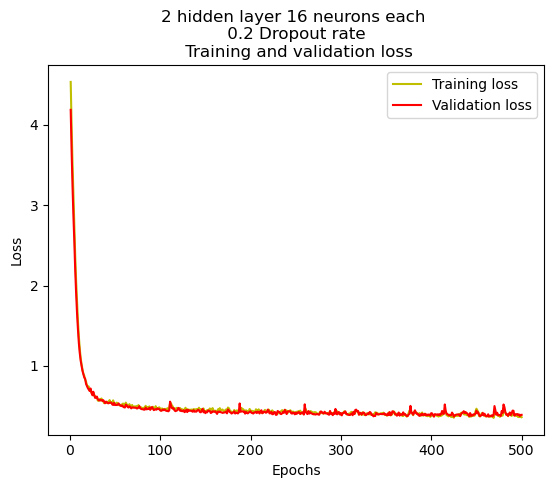

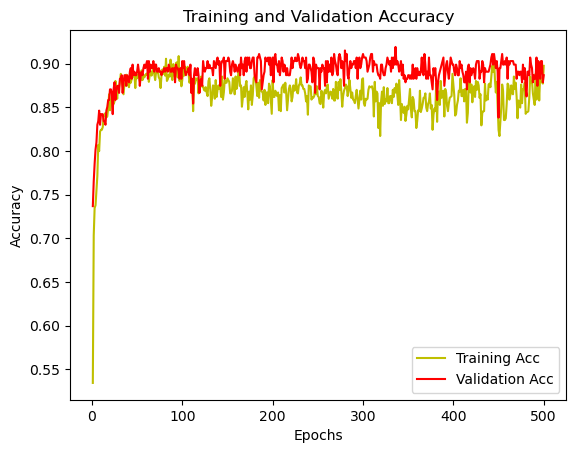

In [93]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('2 hidden layer 16 neurons each \n 0.2 Dropout rate \n Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label = 'Training Acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# We see that the model is no longer overfitting. 
# Given extensive testing we have found the following improvements:

# We can improve the model by having 32 neurons in the first layer and 16 in the second layer
# Additionally we will increase the number of epochs to 1000 
# We will also reduce the learning rate to 0.0002.
# The tests showed that the default l1 regularization value of 0.01 was the best value for this model, giving a good balance between low loss and overfitting.

In [155]:
X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values
y = df_features.total_score.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# standardize the X_train
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train = np.where(y_train < 100, 0, 1)
y_test_cat = np.where(y_test < 100, 0, 1)

# Define the model
l1 = 0.01

model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l1(l1)))
model.add(Dropout(0.2))
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l1(l1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Use the function when compiling the model
model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Define the class weights using the formula: weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)
weight_for_0 = len(df_features) / (len(df_features[df_features.label == 0]) * 2)
weight_for_1 = len(df_features) / (len(df_features[df_features.label == 1]) * 2)
weights = {0: weight_for_0, 1: weight_for_1}

# save the weights giving the lowest validation loss
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='models/final_weights.h5', verbose=0, save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test_cat), epochs=1000, batch_size=64, class_weight=weights, verbose=0) 

c:\Users\frede\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


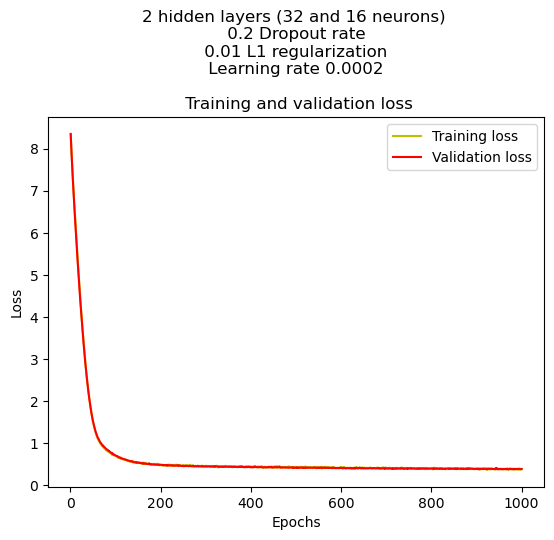

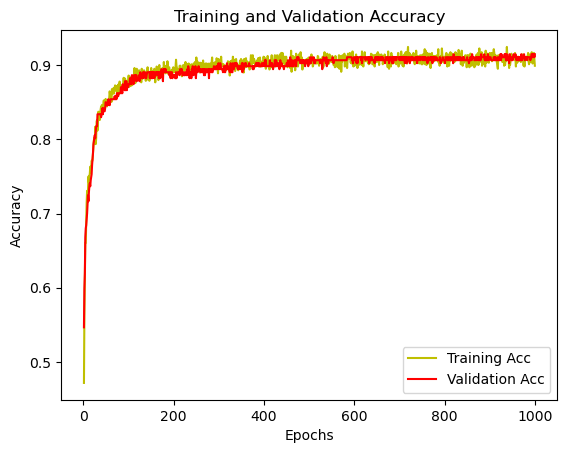

In [156]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('2 hidden layers (32 and 16 neurons) \n 0.2 Dropout rate \n 0.01 L1 regularization \n Learning rate 0.0002 \n \n Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label = 'Training Acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

8/8 [==============================] - 0s 2ms/step


C:\Users\frede\AppData\Local\Temp\ipykernel_23808\1372354960.py:25: RuntimeWarning: invalid value encountered in scalar divide
  positive_prediction_rate = tp / (tp + fp)
C:\Users\frede\AppData\Local\Temp\ipykernel_23808\1372354960.py:24: RuntimeWarning: invalid value encountered in scalar divide
  negative_prediction_rate = tn / (tn + fn)


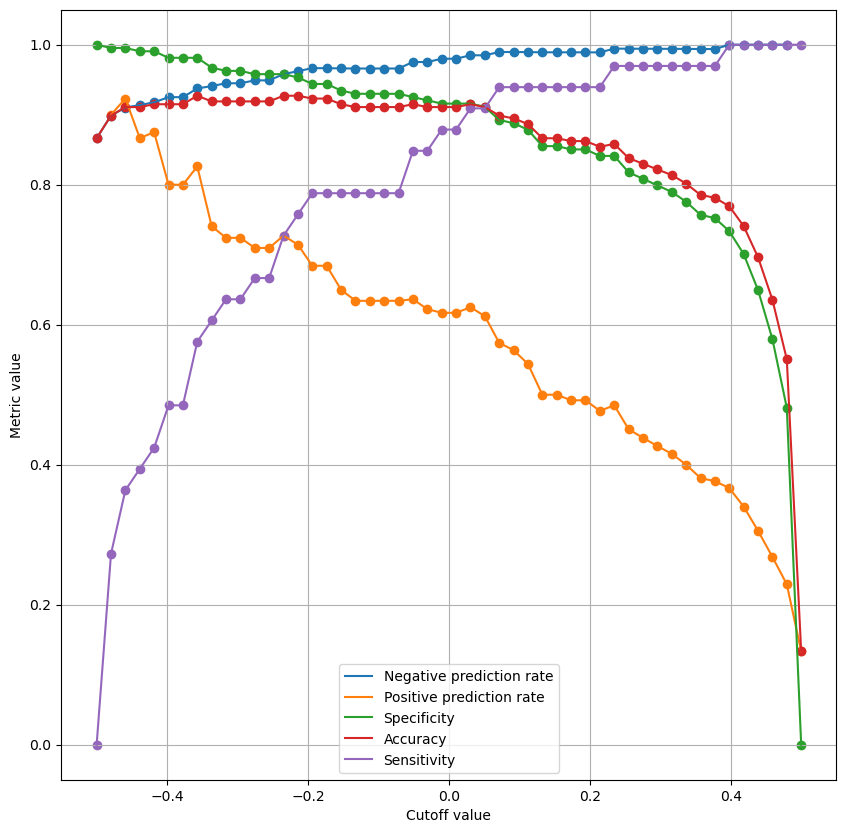

In [157]:
model.load_weights('models/final_weights.h5')

cutoff_values = np.linspace(-0.5, 0.5, 50)

# Predict the probabilities of the positive class
y_pred_prob = model.predict(X_test)

# Initialize lists to store the metrics
negative_prediction_rates = []
positive_prediction_rates = []
specificities = []
accuracies = []
sensitivities = []

# For each cutoff value
for cutoff in cutoff_values:
    # Convert probabilities to class predictions
    y_pred = np.where(y_pred_prob > 0.5 - cutoff, 1, 0)
    
    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test_cat, y_pred).ravel()
    
    # Calculate the metrics
    negative_prediction_rate = tn / (tn + fn)
    positive_prediction_rate = tp / (tp + fp)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_pred, y_test_cat)
    sensitivity = tp / (tp + fn)
    
    # Record the metrics
    negative_prediction_rates.append(negative_prediction_rate)
    positive_prediction_rates.append(positive_prediction_rate)
    specificities.append(specificity)
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)

# Plot the metrics
plt.figure(figsize=(10, 10))
plt.plot(cutoff_values, negative_prediction_rates, label='Negative prediction rate')
plt.plot(cutoff_values, positive_prediction_rates, label='Positive prediction rate')
plt.plot(cutoff_values, specificities, label='Specificity')
plt.plot(cutoff_values, accuracies, label='Accuracy')
plt.plot(cutoff_values, sensitivities, label='Sensitivity')
plt.scatter(cutoff_values, negative_prediction_rates)
plt.scatter(cutoff_values, positive_prediction_rates)
plt.scatter(cutoff_values, specificities)
plt.scatter(cutoff_values, accuracies)
plt.scatter(cutoff_values, sensitivities)
plt.xlabel('Cutoff value')
plt.ylabel('Metric value')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
cutoff_values

array([-0.5       , -0.47959184, -0.45918367, -0.43877551, -0.41836735,
       -0.39795918, -0.37755102, -0.35714286, -0.33673469, -0.31632653,
       -0.29591837, -0.2755102 , -0.25510204, -0.23469388, -0.21428571,
       -0.19387755, -0.17346939, -0.15306122, -0.13265306, -0.1122449 ,
       -0.09183673, -0.07142857, -0.05102041, -0.03061224, -0.01020408,
        0.01020408,  0.03061224,  0.05102041,  0.07142857,  0.09183673,
        0.1122449 ,  0.13265306,  0.15306122,  0.17346939,  0.19387755,
        0.21428571,  0.23469388,  0.25510204,  0.2755102 ,  0.29591837,
        0.31632653,  0.33673469,  0.35714286,  0.37755102,  0.39795918,
        0.41836735,  0.43877551,  0.45918367,  0.47959184,  0.5       ])

Negative prediction rate: 0.9849246231155779
Positive prediction rate: 0.625
Specificity: 0.9158878504672897
Accuracy: 0.9149797570850202
Sensitivity: 0.9090909090909091


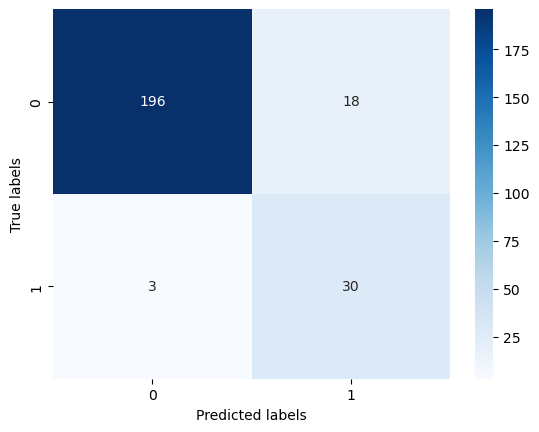

In [158]:
import seaborn as sns
# we set the cutoff value to 0.5 - c
c = 0.03
cutoff = 0.5 - c
y_pred = np.where(y_pred_prob > cutoff, 1, 0)

# Generate the confusion matrix
cm = confusion_matrix(y_test_cat, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Calculate the metrics
tn, fp, fn, tp = cm.ravel()
negative_prediction_rate = tn / (tn + fn)
positive_prediction_rate = tp / (tp + fp)
specificity = tn / (tn + fp)
accuracy = accuracy_score(y_pred, y_test_cat)
sensitivity = tp / (tp + fn)

print(f'Negative prediction rate: {negative_prediction_rate}')
print(f'Positive prediction rate: {positive_prediction_rate}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')
print(f'Sensitivity: {sensitivity}')

In [159]:
for i in range(len(y_pred)):
    if y_pred[i] != y_test_cat[i]:
        print(f'predicted {y_pred[i]} but true was {y_test[i]}')

predicted [1] but true was 64.5
predicted [1] but true was 0.0
predicted [1] but true was 0.0
predicted [1] but true was 52.2
predicted [0] but true was 564.4
predicted [1] but true was 31.6
predicted [1] but true was 24.8
predicted [1] but true was 0.0
predicted [1] but true was 55.1
predicted [1] but true was 27.5
predicted [0] but true was 157.9
predicted [1] but true was 66.1
predicted [1] but true was 26.1
predicted [1] but true was 0.0
predicted [1] but true was 88.4
predicted [1] but true was 71.2
predicted [1] but true was 58.7
predicted [0] but true was 116.7
predicted [1] but true was 34.9
predicted [1] but true was 8.2
predicted [1] but true was 0.0


In [160]:
# save the model using json
model_json = model.to_json()
with open("models/final_model.json", "w") as json_file:
    json_file.write(model_json)

In [119]:
# Test different values for the L1 regularization

# Define the K-fold cross validator
kfold = KFold(n_splits=5, random_state=8, shuffle=True)

# Define the C values to test
C_values = np.logspace(-5, 1, 20)

mean_errors_train = []
mean_errors_test = []

X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values

scaler.fit(X)
X = scaler.transform(X)

y = df_features.label.values

# For each C value
for C in C_values:
    fold_errors_train = []
    fold_errors_test = []
    
    # For each fold
    for train_index, val_index in kfold.split(X):
        print(f"Training with C={C}, fold {len(fold_errors_train)+1}, {len(mean_errors_train)}/20")
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # Create a neural network model with L1 penalty
        model = Sequential()
        model.add(Dense(32, input_dim=X.shape[1], activation='relu', kernel_regularizer=regularizers.l1(C)))
        model.add(Dropout(0.2))
        model.add(Dense(16, input_dim=X.shape[1], activation='relu', kernel_regularizer=regularizers.l1(C)))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

        # Define the class weights
        weight_for_0 = len(df_features) / (len(df_features[df_features.label == 0]) * 2)
        weight_for_1 = len(df_features) / (len(df_features[df_features.label == 1]) * 2)
        weights = {0: weight_for_0, 1: weight_for_1}

        # Train the model
        model.fit(X_train_fold, y_train_fold, epochs=500, batch_size=64, class_weight=weights, verbose=0)
        
        # Predict on the training and validation sets
        y_pred_train = model.predict(X_train_fold)
        y_pred_test = model.predict(X_val_fold)

        y_pred_train = np.hstack([1 - y_pred_train, y_pred_train])
        y_pred_test = np.hstack([1 - y_pred_test, y_pred_test])
    
        error_train = log_loss(y_train_fold, y_pred_train[:, 1])
        error_test = log_loss(y_val_fold, y_pred_test[:, 1])
        
        # Record the errors
        fold_errors_train.append(error_train)
        fold_errors_test.append(error_test)
    
    # Calculate the mean errors for this C value
    mean_error_train = np.mean(fold_errors_train)
    mean_error_test = np.mean(fold_errors_test)
    mean_errors_train.append(mean_error_train)
    mean_errors_test.append(mean_error_test)

Training with C=1e-05, fold 1, 0/20
8/8 [==============================] - 0s 1ms/step
Training with C=1e-05, fold 2, 0/20
8/8 [==============================] - 0s 2ms/step
Training with C=1e-05, fold 3, 0/20
8/8 [==============================] - 0s 1ms/step
Training with C=1e-05, fold 4, 0/20
8/8 [==============================] - 0s 1ms/step
Training with C=1e-05, fold 5, 0/20
8/8 [==============================] - 0s 1ms/step
Training with C=2.06913808111479e-05, fold 1, 1/20
8/8 [==============================] - 0s 1ms/step
Training with C=2.06913808111479e-05, fold 2, 1/20
8/8 [==============================] - 0s 1ms/step
Training with C=2.06913808111479e-05, fold 3, 1/20
8/8 [==============================] - 0s 2ms/step
Training with C=2.06913808111479e-05, fold 4, 1/20
8/8 [==============================] - 0s 1ms/step
Training with C=2.06913808111479e-05, fold 5, 1/20
8/8 [==============================] - 0s 1ms/step
Training with C=4.281332398719396e-05, fold 1, 2/20
8/8

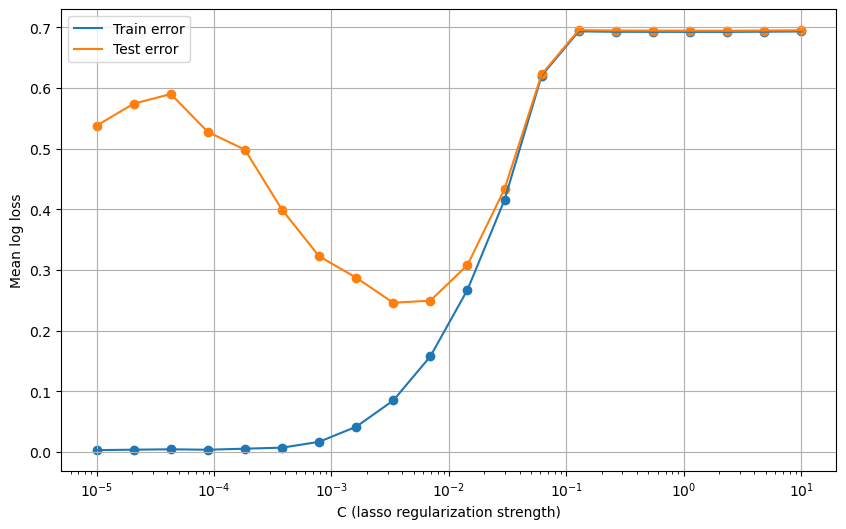

In [120]:
# Plot the mean errors for each C
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, mean_errors_train, label='Train error') 
plt.semilogx(C_values, mean_errors_test, label='Test error')
plt.scatter(C_values, mean_errors_train)
plt.scatter(C_values, mean_errors_test)
plt.xlabel('C (lasso regularization strength)')
plt.ylabel('Mean log loss')
plt.legend()
plt.grid(True)
plt.show()